In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette('bright')
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import fftpack
import datetime
from sklearn import mixture
import warnings
warnings.filterwarnings('ignore')
from scipy import fft

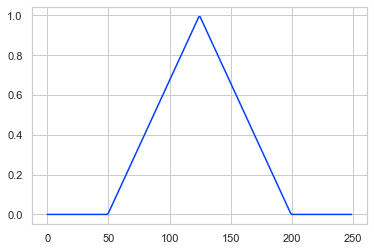

In [2]:
from scipy import signal
x = np.arange(0, 250, 1)
y = np.zeros(250)
y[0:50] = 0
y[50:200] = signal.triang(150)
y[200:250] = 0
plt.plot(x, y)
plt.show()

In [3]:
#x = np.arange(1, 31, 1)
signal_3 = pd.DataFrame(zip(x,y),columns=['Time','Value'])

# GMM on actual time series

In [4]:
dfx = signal_3
lowest_bic = np.infty
bic = []
n_components_range = range(1, 50)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [5]:
print(best_gmm, '\n')
print('WEIGHTS -', best_gmm.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm.means_, '\n')

GaussianMixture(n_components=4) 

WEIGHTS - [0.2 0.2 0.3 0.3] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[2.24500000e+02 2.69342236e-14]
 [2.45000000e+01 2.69342236e-14]
 [8.70000000e+01 5.00000000e-01]
 [1.62000000e+02 5.00000000e-01]] 



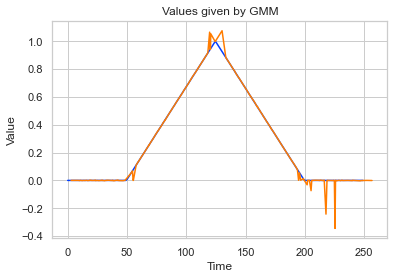

In [6]:
z,_ = best_gmm.sample(250)
plt.title('Actual data')
sns.lineplot(signal_3['Time'], signal_3['Value'])
#plt.show()
plt.title('Values given by GMM')
sns.lineplot(z[:,0],z[:,1])
plt.show()

# GMM on abs FFT

In [7]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    fft_data = pd.DataFrame(zip(np.abs(f[:N//2+1]),np.abs(yf[:N//2+1])),columns=['Freq','Ampli'])
    return fft_data

In [8]:
freq_ampli = freq(signal_3)

<AxesSubplot:xlabel='Freq', ylabel='Ampli'>

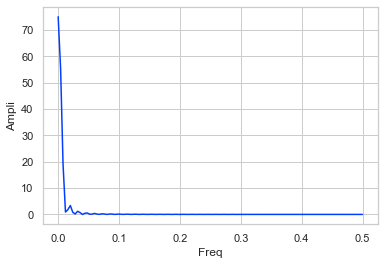

In [9]:
#plt.figure(figsize=(10,6))
sns.lineplot(freq_ampli['Freq'], freq_ampli['Ampli'])
#plt.xlim(-0.1, 0.1)

In [10]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 50)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm
best_gmm1 = GMM_fit(freq_ampli)

In [11]:
print(best_gmm1, '\n')
print('WEIGHTS -', best_gmm1.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm1.means_, '\n')

GaussianMixture(covariance_type='diag', n_components=10) 

WEIGHTS - [0.08051556 0.00793651 0.00793651 0.00793651 0.30672333 0.00793651
 0.00793651 0.05972349 0.22961042 0.28374467] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[7.91533956e-02 1.30079534e-01]
 [0.00000000e+00 7.50000000e+01]
 [4.00000000e-03 5.52615252e+01]
 [8.00000000e-03 1.90908794e+01]
 [2.79542320e-01 6.41883205e-03]
 [1.60000000e-02 1.82244031e+00]
 [2.00000000e-02 3.37514749e+00]
 [3.65515656e-02 6.64516285e-01]
 [1.49437485e-01 2.78348216e-02]
 [4.26469425e-01 1.28255824e-03]] 



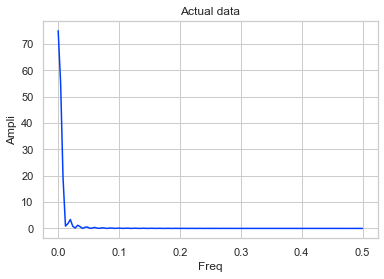

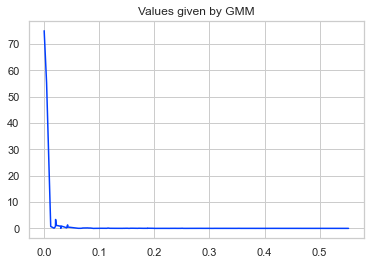

In [12]:
z2,_ = best_gmm1.sample(126)
plt.title('Actual data')
sns.lineplot(freq_ampli['Freq'], freq_ampli['Ampli'])
plt.show()
plt.title('Values given by GMM')
sns.lineplot(z2[:,0],z2[:,1])
plt.show()

# GMM on FFT of actual time series

In [13]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    freq_ampli_real = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].real),columns=['Freq','Ampli'])
    freq_ampli_img = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].imag),columns=['Freq','Ampli'])
    return freq_ampli_real,freq_ampli_img
freq_ampli3,freq_ampli3i = freq(signal_3)

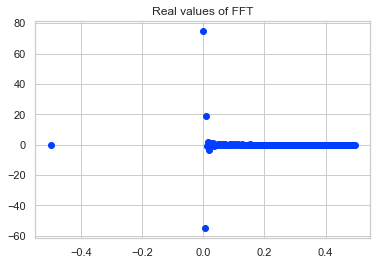

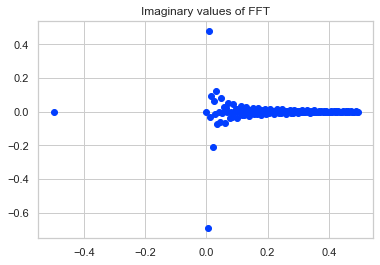

In [14]:
plt.scatter(freq_ampli3['Freq'], freq_ampli3['Ampli'])
plt.title('Real values of FFT')
plt.show()
plt.scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
plt.title('Imaginary values of FFT')
plt.show()

In [15]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 50)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm

In [16]:
best_gmm0 = GMM_fit(freq_ampli3)                        # GMM on real part of FFT data
best_gmm0i = GMM_fit(freq_ampli3i)                      # GMM on imaginary part of FFT data

In [17]:
print(best_gmm0, '\n')
print('WEIGHTS -', best_gmm0.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0.means_, '\n')

GaussianMixture(covariance_type='diag', n_components=11) 

WEIGHTS - [0.00793651 0.00793651 0.00793651 0.00793651 0.30348577 0.00793651
 0.02379136 0.04305971 0.23523851 0.00793651 0.3468056 ] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[-5.00000000e-01  0.00000000e+00]
 [ 0.00000000e+00  7.50000000e+01]
 [ 4.00000000e-03 -5.52571619e+01]
 [ 8.00000000e-03  1.90848503e+01]
 [ 2.46187293e-01 -1.28267496e-04]
 [ 2.00000000e-02 -3.36848741e+00]
 [ 3.46584014e-02  8.36278283e-01]
 [ 3.85375323e-02 -4.59675192e-01]
 [ 1.14887708e-01  7.15441737e-03]
 [ 1.60000000e-02  1.82013849e+00]
 [ 4.07797498e-01  1.29586145e-05]] 



In [18]:
print(best_gmm0i, '\n')
print('WEIGHTS -', best_gmm0i.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0i.means_, '\n')

GaussianMixture(covariance_type='diag', n_components=6) 

WEIGHTS - [0.31549973 0.33043894 0.00793651 0.24548766 0.00793651 0.09270066] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 2.93257391e-01  3.01008572e-06]
 [ 1.33288956e-01 -9.18342275e-05]
 [ 4.00000000e-03 -6.94418529e-01]
 [ 4.33045144e-01  1.75211213e-05]
 [-5.00000000e-01  0.00000000e+00]
 [ 3.37243868e-02  3.55929469e-02]] 



In [19]:
#Sampling
z1,_ = best_gmm0.sample(126)
z1i,_ = best_gmm0i.sample(126)

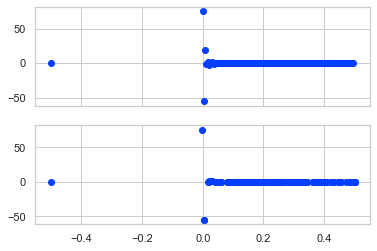

In [20]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(freq_ampli3['Freq'], freq_ampli3['Ampli'])
#plt.show()
ax[1].scatter(z1[:, 0], z1[:, 1])
plt.show()

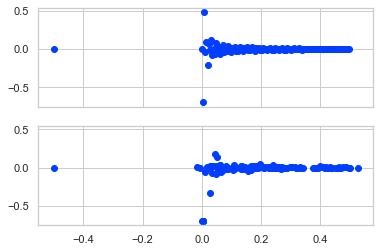

In [21]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
#plt.show()
ax[1].scatter(z1i[:, 0], z1i[:, 1])
plt.show()

In [22]:
sample_1 = pd.DataFrame(zip(z1[:,0],z1[:,1]),columns=['Freq','Ampli'])           
sample_1i = pd.DataFrame(zip(z1i[:,0],z1i[:,1]),columns=['Freq','Ampli'])

In [23]:
sample_1 = sample_1.sort_values(by=['Freq'],ascending=True)     
sample_1 = sample_1[sample_1.Freq > 0]                           
sample_1i = sample_1i.sort_values(by=['Freq'],ascending=True)
sample_1i = sample_1i[sample_1i.Freq > 0]                        

In [24]:
#sample_1 = sample_1[(sample_1.Ampli>1) | (sample_1.Ampli<-1)]
#sample_1i = sample_1i[(sample_1i.Ampli>1) | (sample_1i.Ampli<-1)]

In [25]:
f = fftpack.fftfreq(250)                                    # The frequency corresponding to each value in FFT is stored in 'f'

In [26]:
sd = dict(zip(np.round(f,3),np.zeros(len(f))))

In [27]:
sample_1.Freq = sample_1.Freq.apply(lambda x:round(x,3))       
sample_1i.Freq = sample_1i.Freq.apply(lambda x:round(x,3))

In [28]:
samp_1 = dict(zip(sample_1.Freq,sample_1.Ampli))
samp_1i = dict(zip(sample_1i.Freq,sample_1i.Ampli))

In [29]:
for i in samp_1.keys():
    if i in sd:
        sd[i] = samp_1[i]
        sd[-i] = samp_1[i]
    elif i+0.001 in sd:
        sd[i+0.001] = samp_1[i]
        sd[-(i+0.001)] = samp_1[i]
    elif i-0.001 in sd:
        sd[i-0.001] = samp_1[i]
        sd[-(i-0.001)] = samp_1[i]
sd

{0.0: 0.0,
 0.004: -55.256694609035264,
 0.008: 0.0,
 0.012: 0.0,
 0.016: 0.0,
 0.02: 0.8676842879782842,
 0.024: 0.0,
 0.028: 0.0,
 0.032: 0.5851722531292052,
 0.036: 0.0,
 0.04: -0.4708772866414478,
 0.044: 0.04525197260885717,
 0.048: 0.0,
 0.052: 0.0,
 0.056: -0.13790946532986575,
 0.06: 0.038281995839888505,
 0.064: 0.0,
 0.068: 0.0,
 0.072: 0.0,
 0.076: 0.0,
 0.08: -0.11102945325553282,
 0.084: 0.011096450034022732,
 0.088: 0.09535216978087714,
 0.092: 0.0,
 0.096: 0.0478972814689569,
 0.1: 0.0,
 0.104: 0.04639363116822259,
 0.108: 0.009607413219845774,
 0.112: 0.0,
 0.116: 0.049982698243837165,
 0.12: 0.032108737309185564,
 0.124: 0.0,
 0.128: 0.06447522334117932,
 0.132: -0.0013991668304575958,
 0.136: 0.0694063100984586,
 0.14: 0.0,
 0.144: 0.0033967372785432518,
 0.148: -0.18837529049045104,
 0.152: -0.22987586880515667,
 0.156: 0.13075801121674047,
 0.16: -0.10447524749836495,
 0.164: -0.07155173313990112,
 0.168: 0.0,
 0.172: -0.006826928876080951,
 0.176: 0.0,
 0.18: -0.00

In [30]:
for i in samp_1i.keys():
    if i in sd:
        sd[i] = complex(sd[i],samp_1i[i])
        sd[-i] = complex(sd[i],-(samp_1i[i]))
    elif i+0.001 in sd:
        sd[i+0.001] = complex(sd[i+0.001],samp_1i[i])
        sd[-(i+0.001)] = complex(sd[i+0.001],-(samp_1i[i]))
    elif i-0.001 in sd:
        sd[i-0.001] = complex(sd[i-0.001],samp_1i[i])
        sd[-(i-0.001)] = complex(sd[i-0.001],-(samp_1i[i]))
sd

{0.0: 0.0,
 0.004: (-55.256694609035264-0.6951492997224081j),
 0.008: -0.05776941666641307j,
 0.012: 0.0,
 0.016: 0.0,
 0.02: (0.8676842879782842+0.00799756002838956j),
 0.024: -0.006367996554477392j,
 0.028: -0.3126964752068327j,
 0.032: (0.5851722531292052+0.015317380385788833j),
 0.036: 0.0,
 0.04: (-0.4708772866414478+0.023288934921836382j),
 0.044: (0.04525197260885717+0.17698038560384427j),
 0.048: -0.08217063331554286j,
 0.052: 0.1427160616567153j,
 0.056: (-0.13790946532986575-0.031828762742033084j),
 0.06: 0.038281995839888505,
 0.064: 0.028138419301274066j,
 0.068: 0.0,
 0.072: -0.03689234159750915j,
 0.076: 0.0,
 0.08: (-0.11102945325553282+0.022542061838917993j),
 0.084: (0.011096450034022732-0.012930108836647476j),
 0.088: (0.09535216978087714-0.023288870501063593j),
 0.092: 0.0,
 0.096: 0.0478972814689569,
 0.1: 0.0,
 0.104: 0.04639363116822259,
 0.108: (0.009607413219845774+0.02945108804522333j),
 0.112: 0.0,
 0.116: 0.049982698243837165,
 0.12: 0.032108737309185564,
 0.

In [31]:
value = list(sd.values())

# Final IFFT 

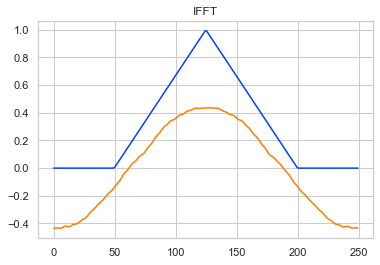

In [32]:
ift = fft.ifft(value)
plt.title('IFFT')
plt.plot(signal_3['Time'], signal_3['Value'])
plt.plot(x,ift)